# Semantic Segmentation:
이미지 내에서 픽셀 단위로 객체를 분류해내는 작업을 말합니다. 여기서 객체란 Object 즉, 사람, 자동차, 나무, 자전거 등을 말하며 Deep learning 에서는 이를 class 라고 표현합니다.
### ref: https://junstar92.tistory.com/150, https://m.blog.naver.com/PostView.nhn?blogId=mincheol9166&logNo=221736294296&navType=tl
![대체 텍스트](https://miro.medium.com/max/700/1*8Nwk_IdGpe235Nsfewpucg.png)

from Fei-Fei Li Stanford Course — Detection And Segmentation

### STEP 1: 데이터셋과 읽어들이기

In [ ]:
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "ref/Lung_Segmentation/"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)
#print(file_headers)

X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

count = 0
for fh in file_headers:
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))
    
    img = imread(f1)[:,:,:IMG_CHANNELS]
    mask = imread(l1)
    mask = np.expand_dims(mask, axis=-1)

    X_all[count] = img
    y_all[count] = mask
    
    count += 1

### **딥러닝을 위한 데이터 전처리**

In [ ]:
X_all = X_all.astype('float32') / 255.
y_all = y_all.astype('float32')

### **학습, 검증, 테스트 데이터 셋으로 분리**

In [ ]:
# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 1)
y_valid (91, 256, 256, 1)
y_test (114, 256, 256, 1)


### STEP 2: 데이터 살펴보기

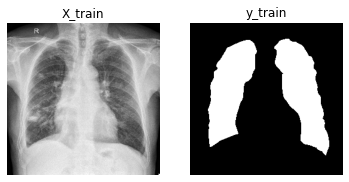

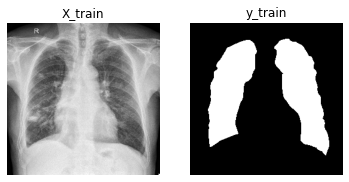

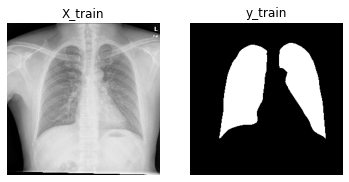

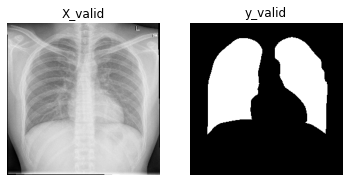

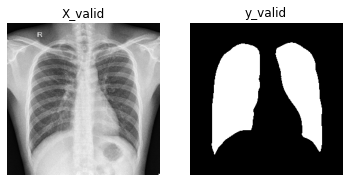

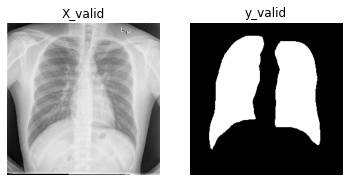

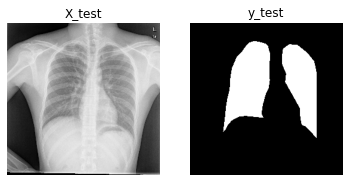

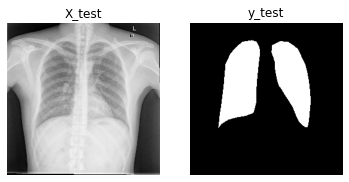

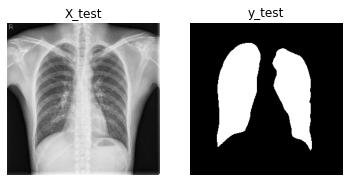

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]), 'gray')
        plt.axis('off')
        plt.show()
        
plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')
plotTrainData(X_test,y_test, 'test')

## STEP 3: VGG16 네트워크 다시 보기
![대체 텍스트](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

def vgg16():
    inputs = Input(shape=(256, 256, 3,), name="VGGInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    x = Flatten()(x)
    x = Dense(4096, activation=relu)(x)
    pred = Dense(1000, activation=softmax)(x)
        
    return Model(inputs=inputs, outputs=pred)

### STEP 4: 첫 번째 영상분할 모델 (FCN32s)
FCN (Fully Convolutional Network)

In [ ]:
from tensorflow.keras.layers import Activation

def fcn32s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)
        
    conv_t1 = UpSampling2D(size = (32,32))(pool_5)    
    conv_t2 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv_t1)
    
    pred = Activation('sigmoid')(conv_t2)
    
    return Model(inputs=inputs, outputs=pred)

In [ ]:
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras.optimizers import SGD

# build the model
model = fcn32s()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-32s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### STEP 5: 결과 확인하기

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN     

    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()
    
    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    preds_valid_t = (preds_valid > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_valid")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_valid")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_valid_t[0][:,:,0], 'gray')
    plt.show()
    
    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

### STEP 6: 두 번째 모델 (FCN8s)

In [ ]:
def fcn8s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)
    
    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)
    
    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    conv_t1 = UpSampling2D(size = (2,2))(conv8)     
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    conv_t2 = UpSampling2D(size = (2,2))(fuse_1)
    fuse_2 = Add()([conv_t2,score_pool3])
   
    conv_t3 = UpSampling2D(size = (8,8))(fuse_2)
    
    pred = Activation('sigmoid')(conv_t3)
    
    return Model(inputs=inputs, outputs=pred)

In [ ]:
# build the model
model = fcn8s()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-8s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)